In [65]:
!pip install imblearn
!pip install seaborn

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

input_file_path = '../data/feature_extraction/BERT_Features.csv'
df = pd.read_csv(input_file_path)

# BERT features start from the 8th column
X = df.iloc[:, 7:].values  
y = df['Sentiment']

# Encoding categorical labels
y_encoded = pd.get_dummies(y).values

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the sampling strategy
sampling_strategy = {0: df['Sentiment'].value_counts()['negative'], 
                     1: df['Sentiment'].value_counts()['neutral'],
                     2: df['Sentiment'].value_counts()['positive']}

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Reshape X to have 3 dimensions [samples, timesteps, features]
X_train_smote = np.expand_dims(X_train_smote, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Define LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_smote.shape[1], X_train_smote.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_train_smote.shape[1], activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_smote, y_train_smote, epochs=20, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
142/142 [==============================] - 2s 4ms/step - loss: 0.6897 - accuracy: 0.6869 - val_loss: 0.5385 - val_accuracy: 0.7876
Epoch 2/20
142/142 [==============================] - 0s 2ms/step - loss: 0.6030 - accuracy: 0.7480 - val_loss: 0.5292 - val_accuracy: 0.7850
Epoch 3/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5771 - accuracy: 0.7615 - val_loss: 0.4679 - val_accuracy: 0.8186
Epoch 4/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5613 - accuracy: 0.7727 - val_loss: 0.4728 - val_accuracy: 0.8088
Epoch 5/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5591 - accuracy: 0.7712 - val_loss: 0.4547 - val_accuracy: 0.8239
Epoch 6/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5402 - accuracy: 0.7774 - val_loss: 0.4397 - val_accuracy: 0.8345
Epoch 7/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5150 - accuracy: 0.7900 - val_loss: 0.4142 - val_accuracy: 0.8451
Epoch 

In [5]:
print("Negative:", y.value_counts()['negative'])
print("Neutral:", y.value_counts()['neutral'])
print("Positive:", y.value_counts()['positive'])

Negative: 3281
Neutral: 152
Positive: 2216


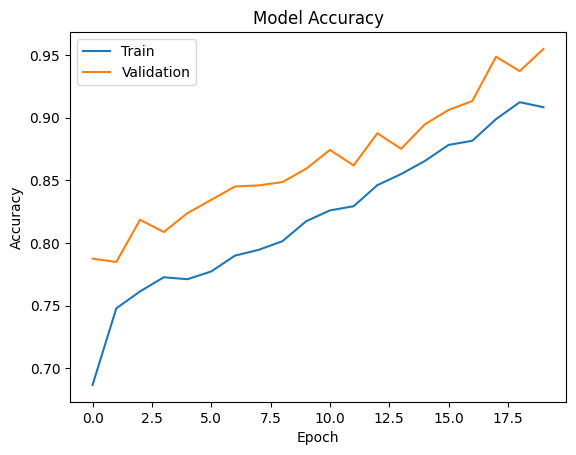

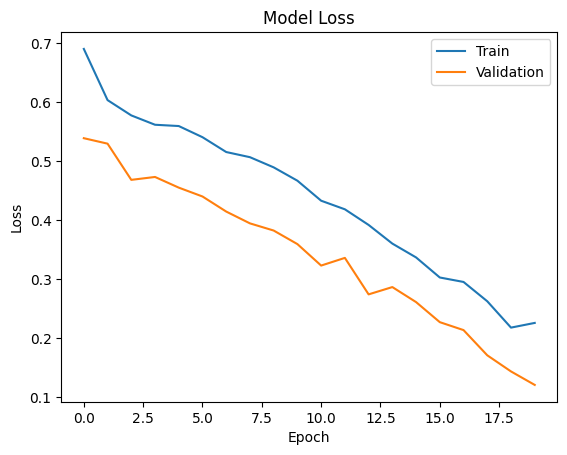

In [6]:
import matplotlib.pyplot as plt

# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [7]:
import pickle
# Save the model
pickle.dump(model, open('../model/lstm_model.pkl', 'wb'))

36/36 [==============================] - 0s 843us/step


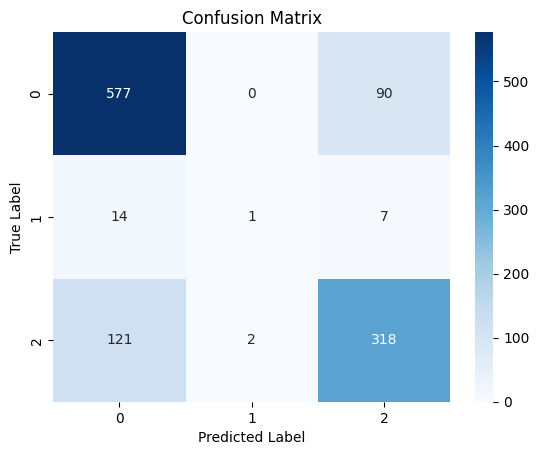

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       667
           1       0.33      0.05      0.08        22
           2       0.77      0.72      0.74       441

    accuracy                           0.79      1130
   macro avg       0.64      0.54      0.55      1130
weighted avg       0.78      0.79      0.79      1130



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes))